In [45]:
# ! conda install -c pytorch torchvision
# ! pip install skillsnetwork tqdm
# !pip install  skillsnetwork

In [46]:
import os
import uuid
import shutil
import json
from botocore.client import Config
import ibm_boto3
import copy
from datetime import datetime
from skillsnetwork import cvstudio 
from sklearn.metrics import accuracy_score

In [47]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
from ipywidgets import IntProgress
import time 

In [48]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

In [49]:
def plot_stuff(COST,ACC):    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

In [50]:
def imshow_(inp, title=None):
    """Imshow for Tensor."""
    inp = inp .permute(1, 2, 0).numpy() 
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()

In [51]:
def result(model,x,y):
    #x,y=sample
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)
    
    if yhat.item()!=y:
        text="predicted: {} actual: {}".format(str(yhat.item()),y)
        print(text)

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)


the device type is cpu


In [53]:

# Get the Dataset
# Initialize the CV Studio Client
cvstudioClient = cvstudio.CVStudio()
# # Download All Images
cvstudioClient.downloadAll()

100%|██████████| 827/827 [04:19<00:00,  3.18it/s]


In [54]:
percentage_train=0.9
train_set=cvstudioClient.getDataset(train_test='train',percentage_train=percentage_train)
val_set=cvstudioClient.getDataset(train_test='test',percentage_train=percentage_train)

defult transform for pretrained model resnet18
this is the training set
defult transform for pretrained model resnet18
this is the test set


We can plot some of our dataset:


(224, 224, 3)


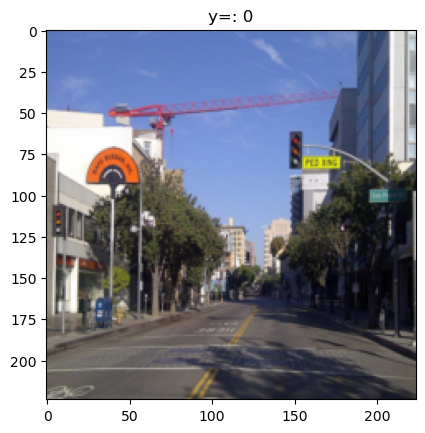

(224, 224, 3)


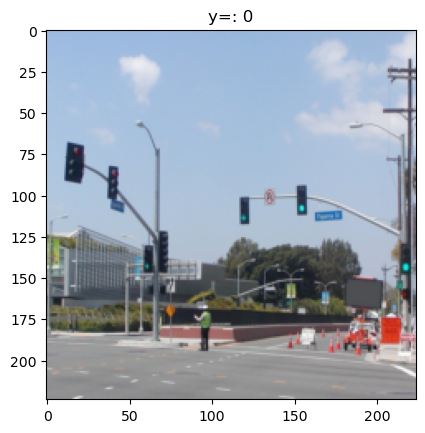

(224, 224, 3)


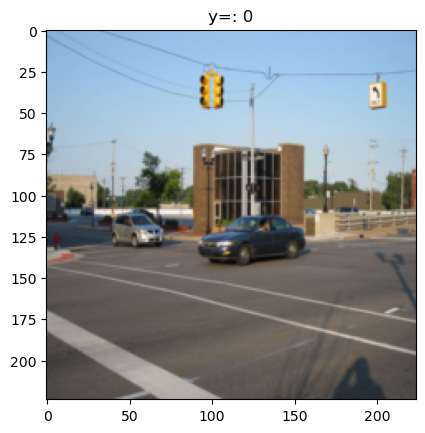

In [55]:
i=0

for x,y  in val_set:
    imshow_(x,"y=: {}".format(str(y.item())))
    i+=1
    if i==3:
        break

In [56]:
n_epochs=10

In [57]:
batch_size=32

In [58]:
lr=0.000001

In [59]:
momentum=0.9

In [60]:
lr_scheduler=True
base_lr=0.001
max_lr=0.01

# Load Model and Train


In [61]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs,print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    #global:val_set
    n_test = len(val_set)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
        # Loop through the data in loader
    print("The first epoch should take several minutes")
    for epoch in tqdm(range(n_epochs)):
        
        loss_sublist = []
        # Loop through the data in loader

        for x, y in train_loader:
            x, y=x.to(device), y.to(device)
            model.train() 

            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
        print("epoch {} done".format(epoch) )

        scheduler.step()    
        loss_list.append(np.mean(loss_sublist))
        correct = 0


        for x_test, y_test in validation_loader:
            x_test, y_test=x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy>accuracy_best:
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        
        if print_:
            print('learning rate',optimizer.param_groups[0]['lr'])
            print("The validaion  Cost for each epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy)) 
    model.load_state_dict(best_model_wts)    
    return accuracy_list,loss_list, model

In [62]:
model = models.resnet18(pretrained=True)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
 for param in model.parameters():
        param.requires_grad = False
    

In [64]:
n_classes=train_set.n_classes
n_classes

2

In [65]:
# Type your code here
model.fc = nn.Linear(512, n_classes)

In [66]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [67]:
criterion = nn.CrossEntropyLoss()

In [68]:

train_loader = torch.utils.data.DataLoader(dataset=train_set , batch_size=batch_size,shuffle=True)
validation_loader= torch.utils.data.DataLoader(dataset=val_set , batch_size=1)

In [69]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)


In [70]:
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01,step_size_up=5,mode="triangular2")

In [71]:
start_datetime = datetime.now()
start_time=time.time()

accuracy_list,loss_list, model=train_model(model,train_loader , validation_loader, criterion, optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("elapsed time", elapsed_time )

  0%|          | 0/10 [00:00<?, ?it/s]

The first epoch should take several minutes
epoch 0 done


 10%|█         | 1/10 [01:50<16:35, 110.58s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 1: 0.40895258511106175
The validation accuracy for epoch 1: 0.927710843373494
epoch 1 done


 20%|██        | 2/10 [03:35<14:16, 107.12s/it]

learning rate 0.0046
The validaion  Cost for each epoch 2: 0.2488400967170795
The validation accuracy for epoch 2: 0.963855421686747
epoch 2 done


 30%|███       | 3/10 [05:16<12:10, 104.41s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 3: 0.19450590573251247
The validation accuracy for epoch 3: 0.963855421686747
epoch 3 done


 40%|████      | 4/10 [07:03<10:32, 105.44s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 4: 0.1590102600554625
The validation accuracy for epoch 4: 0.9518072289156626
epoch 4 done


 50%|█████     | 5/10 [08:49<08:48, 105.69s/it]

learning rate 0.010000000000000002
The validaion  Cost for each epoch 5: 0.13217542755107084
The validation accuracy for epoch 5: 0.963855421686747
epoch 5 done


 60%|██████    | 6/10 [10:32<06:58, 104.74s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 6: 0.14209352945908904
The validation accuracy for epoch 6: 0.891566265060241
epoch 6 done


 70%|███████   | 7/10 [12:11<05:08, 102.77s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 7: 0.16379764769226313
The validation accuracy for epoch 7: 0.963855421686747
epoch 7 done


 80%|████████  | 8/10 [13:55<03:26, 103.11s/it]

learning rate 0.0046
The validaion  Cost for each epoch 8: 0.10213432693853974
The validation accuracy for epoch 8: 0.963855421686747
epoch 8 done


 90%|█████████ | 9/10 [15:36<01:42, 102.64s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 9: 0.10134821268729866
The validation accuracy for epoch 9: 0.9518072289156626
epoch 9 done


100%|██████████| 10/10 [17:15<00:00, 103.59s/it]

learning rate 0.001
The validaion  Cost for each epoch 10: 0.0965219580490763
The validation accuracy for epoch 10: 0.963855421686747
elapsed time 1036.0528070926666


In [72]:


parameters = {
    'epochs': n_epochs,
    'learningRate': lr,
    'momentum':momentum,
    'percentage used training':percentage_train,
    "learningRatescheduler": {"lr_scheduler":lr_scheduler,"base_lr":base_lr, "max_lr" :max_lr}
    
    
}
result = cvstudioClient.report(started=start_datetime, completed=end_datetime, parameters=parameters, accuracy={ 'accuracy': accuracy_list, 'loss': loss_list })

if result.ok:
    print('Done')

Congratulations your results have been reported back to CV Studio!


In [73]:
# Save the model to model.pt
torch.save(model.state_dict(), 'model.pt')

# Save the model and report back to CV Studio
result = cvstudioClient.uploadModel('model.pt', {'numClasses': n_classes})

File Uploaded


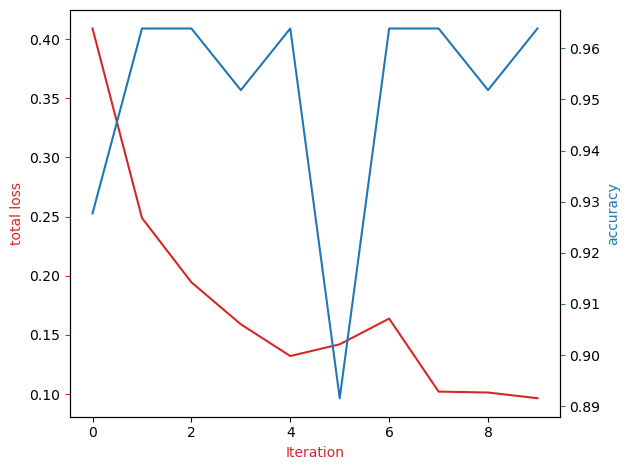

In [74]:
plot_stuff(loss_list,accuracy_list)

In [75]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, n_classes)
model.load_state_dict(torch.load( "model.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Check Model

(224, 224, 3)


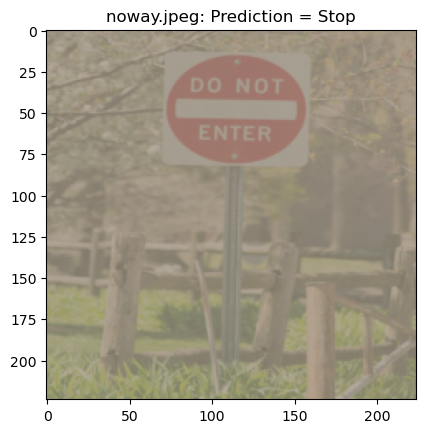

In [77]:
imageNames = ['noway.jpeg']
for imageName in imageNames:
    image = Image.open(imageName)
    transform = composed = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    x = transform(image)
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)

    prediction = "Not Stop"
    if yhat == 1:
        prediction ="Stop"
    imshow_(transform(image),imageName+": Prediction = "+prediction)